## Plot QNMs Using Leaver's Method for Kerr
---

In [3]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Make plotting inline
%matplotlib inline

# Import Needed Things
from kerr.pttools import leaver_workfunction

#
from kerr import leaver # loads tabulated QNM data
from kerr import localmins # finds local minima of a 2D array
from kerr import mapqnms

# Import maths stuffs
from numpy import linspace,linalg,zeros,log,meshgrid,array
import scipy.interpolate as intpl
interp2d = intpl.interp2d

#
import skimage
from scipy.optimize import fmin as fminsearch

# Setup plotting backend
import matplotlib.pyplot as my
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define parameters of use: limits, QNM indeces, etc

In [4]:
# Define QNM l and m
l,m = 2,0 
n = 0; s = -2
# Define Kerr parameter to use
jf = 0.68
# Define region of evaluation
N = 100
#
cw_leaver = []
cs_leaver = []
for nn in range(4):
    tmp = leaver( jf, l, m, nn )
    cw_leaver.append(tmp[0])
    cs_leaver.append(tmp[1])
#
cwm_leaver = []
csm_leaver = []
for nn in range(4):
    tmp = leaver( -jf, l, m, nn )
    cwm_leaver.append(tmp[0])
    csm_leaver.append(tmp[1])
#
wr_min0 = -max(abs(array(cwm_leaver).real))
wr_max0 = max(abs(array(cw_leaver).real))
pad = 0.15*(wr_max0-wr_min0)
wr_range = linspace(wr_min0-pad,wr_max0+pad,N)
wc_range = -abs(cw_leaver[0].imag)*linspace(1.0/10.0,15.0,N)
#
wr_min = min(wr_range)
wr_max = max(wr_range)
wc_min = min(abs(wc_range))
wc_max = max(abs(wc_range))
# Create grid
wr,wc = meshgrid(wr_range,wc_range)

In [5]:
#print cw_leaver[0]
#print cw[0]
#print -max(abs(array(cw_leaver).real))
k = 0
b = 1.0

state0 = b*array( [ cw_leaver[k].real,cw_leaver[k].imag, cs_leaver[k].real,cs_leaver[k].imag ] )
wf = lambda state: linalg.norm(  leaver_workfunction( jf,l,m,state )  )

print '## PROGRADE -- Searching for QNM solution using initial guess\n'+'-'*50
fms_output = fminsearch(func=wf, x0=state0, disp=True, full_output=True )
print
print '## Interpolated value from data file:\n'+'-'*50
print state0/b
print '## Solution from Neadler-Mead:\n'+'-'*50
print fms_output[0]

state0 = b*array( [ cwm_leaver[k].real,cwm_leaver[k].imag, csm_leaver[k].real,csm_leaver[k].imag ] )
wf = lambda state: linalg.norm(  leaver_workfunction( jf,l,-m,state )  )

print '\n%s\n' % (30*'**')

print '## RETROGRADE -- Searching for QNM solution using initial guess\n'+'-'*50
fms_output = fminsearch(func=wf, x0=state0, disp=True, full_output=True )
print
print '## Interpolated value from data file:\n'+'-'*50
print state0/b
print '## Solution from Neadler-Mead:\n'+'-'*50
print fms_output[0]

## PROGRADE -- Searching for QNM solution using initial guess
--------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 52
         Function evaluations: 94

## Interpolated value from data file:
--------------------------------------------------
[ 0.39279161 -0.08480927  3.96432118  0.01619586]
## Solution from Neadler-Mead:
--------------------------------------------------
[ 0.39279161 -0.08480927  3.96432118  0.01619586]

************************************************************

## RETROGRADE -- Searching for QNM solution using initial guess
--------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 99

## Interpolated value from data file:
--------------------------------------------------
[-0.39279161 -0.08480927  3.96432118 -0.01619586]
## Solution from Nead

#### Implement Berti's approximation for the separation constants

In [6]:
#

f = zeros((6,))

f[0] = l*(l+1) - s*(s+1)
f[1] = - 2.0 * m * s*s / ( l*(l+1) )

hapb = max( abs(m), abs(s) )
hamb = m*s/hapb
h = lambda ll: (ll*ll - hapb*hapb) * (ll*ll-hamb*hamb) * (ll*ll-s*s) / ( 2*(l-0.5)*ll*ll*ll*(ll-0.5) )

f[2] = h(l+1) - h(l) - 1
f[3] = 2*h(l)*m*s*s/((l-1)*l*l*(l+1)) - 2*h(l+1)*m*s*s/(l*(l+1)*(l+1)*(l+2))
f[4] = m*m*s*s*s*s*( 4*h(l+1)/(l*l*(l+1)*(l+1)*(l+1)*(l+1)*(l+2)*(l+2)) \
                    - 4*h(l)/((l-1)*(l-1)*l*l*l*l*(l+1)*(l+1)) ) \
                    - (l+2)*h(l+1)*h(l+2)/(2*(l+1)*(2*l+3)) \
                    + h(l+1)*h(l+1)/(2*l+2) + h(l)*h(l+1)/(2*l*l+2*l) - h(l)*h(l)/(2*l) \
                    + (l-1)*h(l-1)*h(l)/(4*l*l-2*l)

## NOTE that this term diverges for l=2
# f[5] = m*m*m*s*s*s*s*s*s*( 8.0*h(l)/(l*l*l*l*l*l*(l+1)*(l+1)*(l+1)*(l-1)*(l-1)*(l-1)) \
#                          - 8.0*h(l+1)/(l*l*l*(l+1)*(l+1)*(l+1)*(l+1)*(l+1)*(l+1)*(l+2)*(l+2)*(l+2)) ) \
#           + m*s*s*h(l) * (-h(l+1)*(7.0*l*l+7*l+4)/(l*l*l*(l+2)*(l+1)*(l+1)*(l+1)*(l-1)) \
#                           -h(l-1)*(3.0*l-4)/(l*l*l*(l+1)*(2*l-1)*(l-2)) ) \
#           + m*s*s*( (3.0*l+7)*h(l+1)*h(l+2)/(l*(l+1)*(l+1)*(l+1)*(l+3)*(2*l+3)) \
#                              -(3.0*h(l+1)*h(l+1)/(l*(l+1)*(l+1)*(l+1)*(l+2)) + 3.0*h(l)*h(l)/(l*l*l*(l-1)*(l+1)) ) ) 
            
Aberti = lambda c: sum( f * array([ c**k for k in range(len(f)) ]) )

print Aberti(cw_leaver[0]*jf)
print cs_leaver[0]

(4.00697981206-0.00276487139494j)
(3.96432118204+0.0161958601501j)


#### Use Leaver's Method to map QNM solution space

In [7]:


# Note that x is locally minimal near QNM solution locations
x = zeros( wr.shape )
#
h = 0
print '## Working ',
for i in range(N):
    for j in range(N):
        
        # Fixed Complex Frequency to use
        complex_w = wr_range[i]-1j*abs( wc_range[j] )
        
        #
        A = Aberti( complex_w*jf )
        x[j][i] = sum(abs( array(leaver_workfunction( jf,l,m, [complex_w, A] )) ))
        
#         A0 = Aberti( complex_w*jf )
#         if j==0 or i==0:
#             A0 = Aberti( complex_w*jf )
#         else:
#             A0 = previous_A0

#         #
#         A0 = Aberti(complex_w*jf).conj()
#         # Minimize over separation constant
#         AA0 = [ A0.real, A0.imag ]
#         fun = lambda AA: linalg.norm( array(leaver_workfunction( jf,l,m, [complex_w, AA[0]+1j*AA[1]] )) )
#         X = fminsearch( fun, AA0, disp=False, full_output=True, xtol=wr_range[1]-wr_range[0], maxiter=20 ) # , maxiter=200
#         previous_A0 = X[0][0] + 1j*X[0][1]
#         x[j][i] = X[1]
#         h+=1
        
    print '.',

# Let the people know that calculations have finished
print '## Done.'

## Working  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ## Done.


In [8]:
local_min = localmins(x)
min_x = min(x.reshape(x.size,))
print '\nEvaluation Notes:'
print ' * The smallest workfunction value is %1.4f' % min_x
print ' * There appear to be %i QNM solutions here (i.e. %i local minima)' % (len(array(local_min)[0]),len(array(local_min)[0]))


Evaluation Notes:
 * The smallest workfunction value is 0.1275
 * There appear to be 12 QNM solutions here (i.e. 12 local minima)


#### Plot result

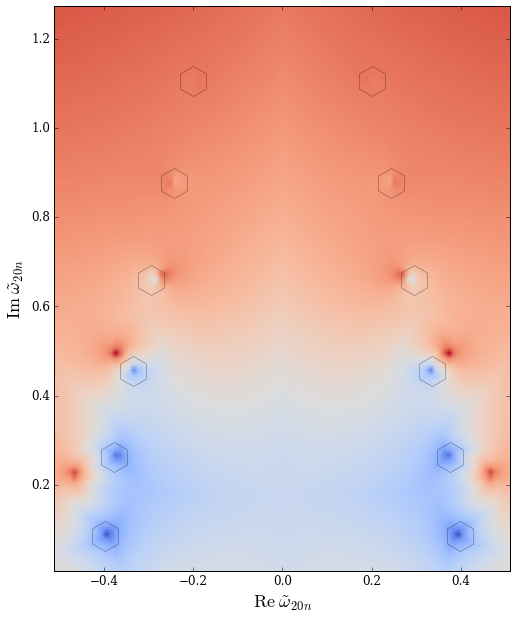

In [9]:
# Setup figure
my.figure(figsize=8*array((wr_max-wr_min, wc_max-wc_min)), dpi=200, facecolor='w', edgecolor='k')

#
# z = x
z = log(x)

#
im = my.imshow(z, interpolation='bilinear', origin='lower',
                cmap=mpl.cm.coolwarm,extent=(wr_min,wr_max,wc_min,wc_max) )



# Plot known QNM locations for l=m=2
mkrsize = 8
mkr = ['+','x','h','o']

for k,w in enumerate(cw_leaver):
    my.plot( w.real,w.imag, mkr[0], markersize=mkrsize, mfc='none', mec='w', mew=1 )
    #my.plot(-w.real,w.imag, mkr[0], markersize=mkrsize, mfc='none', mec='w', mew=1, alpha=0.5 )
    
for k,w in enumerate(cwm_leaver):
    #my.plot( w.real,w.imag, mkr[1], markersize=mkrsize, mfc='none', mec='w', mew=1, alpha=0.5 )
    my.plot(-w.real,w.imag, mkr[1], markersize=mkrsize, mfc='none', mec='w', mew=1 )

# for k,w in enumerate(cw_leaver):
#     my.plot( w.real,w.imag, mkr[2], markersize=30, mfc='none', mec='k', mew=1, alpha=0.3 )
#     #my.plot(-w.real,w.imag, mkr[0], markersize=mkrsize, mfc='none', mec='w', mew=1, alpha=0.5 )
# for k,w in enumerate(cwm_leaver):
#     #my.plot( w.real,w.imag, mkr[1], markersize=mkrsize, mfc='none', mec='w', mew=1, alpha=0.5 )
#     my.plot(-w.real,w.imag, mkr[2], markersize=30, mfc='none', mec='k', mew=1, alpha=0.3 )

for k in range(len(local_min[0])):
    aa = local_min[1][k]
    bb = local_min[0][k]
    my.plot( wr_range[aa], -wc_range[bb],'h', mfc='none', mec='k', ms=30, alpha=0.5 )
    
#
my.xlim( ( wr_min,wr_max ) )
my.ylim( (wc_min,wc_max ) )

# Label Axes
my.xlabel( r'$\mathrm{Re}\;\tilde{\omega}_{%i%i n}$' % (l,m), fontsize=18 )
my.ylabel( r'$\mathrm{Im}\;\tilde{\omega}_{%i%i n}$' % (l,m), fontsize=18 )
# # Add a title
# my.title('Example: Leaver\'s Method for $j_f = %1.2f$ and $(l,m)=(%i,%i)$' % (jf,l,m) )

# Save the figure to the pwd
my.savefig( 'leaver_example_chi%1.4f_l%im%i.pdf' % (jf,l,m) )

In [10]:
print l,m

2 0
